In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy, json
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
# SEED = 147
# SEED = 258
SEED = 369

torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
import torch.optim as optim
from torch.utils import data

In [5]:
cifar_train = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

cifar_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465], # mean=[0.5071, 0.4865, 0.4409] for cifar100
        std=[0.2023, 0.1994, 0.2010], # std=[0.2009, 0.1984, 0.2023] for cifar100
    ),
])

train_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=True, download=True, transform=cifar_train)
test_dataset = datasets.CIFAR10(root="../../../../../_Datasets/cifar10/", train=False, download=True, transform=cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
## demo of train loader
xx, yy = iter(train_loader).next()
xx.shape

torch.Size([32, 3, 32, 32])

# Model

In [8]:
class MlpBLock(nn.Module):
    
    def __init__(self, input_dim, hidden_layers_ratio=[2], actf=nn.GELU):
        super().__init__()
        self.input_dim = input_dim
        #### convert hidden layers ratio to list if integer is inputted
        if isinstance(hidden_layers_ratio, int):
            hidden_layers_ratio = [hidden_layers_ratio]
            
        self.hlr = [1]+hidden_layers_ratio+[1]
        
        self.mlp = []
        ### for 1 hidden layer, we iterate 2 times
        for h in range(len(self.hlr)-1):
            i, o = int(self.hlr[h]*self.input_dim),\
                    int(self.hlr[h+1]*self.input_dim)
            self.mlp.append(nn.Linear(i, o))
            self.mlp.append(actf())
        self.mlp = self.mlp[:-1]
        
        self.mlp = nn.Sequential(*self.mlp)
        
    def forward(self, x):
        return self.mlp(x)

In [9]:
MlpBLock(2, [3,4])

MlpBLock(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): GELU()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): GELU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

## MLP-Mixer 

In [10]:
class MixerBlock(nn.Module):
    
    def __init__(self, patch_dim, channel_dim):
        super().__init__()
        
        self.ln0 = nn.LayerNorm(channel_dim)
        self.mlp_patch = MlpBLock(patch_dim, [2])
        self.ln1 = nn.LayerNorm(channel_dim)
        self.mlp_channel = MlpBLock(channel_dim, [2])
    
    def forward(self, x):
        ## x has shape-> N, nP, nC/hidden_dims; C=Channel, P=Patch
        
        ######## !!!! Can use same mixer on shape of -> N, C, P;
        
        #### mix per patch
        y = self.ln0(x) ### per channel layer normalization ?? 
        y = torch.swapaxes(y, -1, -2)
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        x = x+y
        
        #### mix per channel 
        y = self.ln1(x)
        y = self.mlp_channel(y)
        x = x+y
        return x

In [11]:
class MlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_size:tuple, hidden_expansion:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
        ### find patch dim
        d0 = int(image_dim[-2]/patch_size[0])
        d1 = int(image_dim[-1]/patch_size[1])
        assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
        assert d1*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
#         self.d0, self.d1 = d0, d1 ### number of patches in each axis
        __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
        ### find channel dim
        channel_size = d0*d1 ## number of patches
        
        ### after the number of channels are changed
        init_dim = __patch_size
#         final_dim = int(patch_size[0]*patch_size[1]*hidden_expansion)
        final_dim = int(init_dim*hidden_expansion)

        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
        self.channel_change = nn.Linear(init_dim, final_dim)
        print(f"MLP Mixer : Channes per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
        self.channel_dim = final_dim
        self.patch_dim = channel_size
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            self.mixer_blocks.append(MixerBlock(self.patch_dim, self.channel_dim))
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        
        self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        
        
    def forward(self, x):
        bs = x.shape[0]
        x = self.unfold(x).swapaxes(-1, -2)
        x = self.channel_change(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [12]:
mixer = MlpMixer((1, 28, 28), (4, 4), hidden_expansion=2, num_blocks=1, num_classes=10)
mixer

MLP Mixer : Channes per patch -> Initial:16 Final:32


MlpMixer(
  (unfold): Unfold(kernel_size=(4, 4), dilation=1, padding=0, stride=(4, 4))
  (channel_change): Linear(in_features=16, out_features=32, bias=True)
  (mixer_blocks): Sequential(
    (0): MixerBlock(
      (ln0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=49, out_features=98, bias=True)
          (1): GELU()
          (2): Linear(in_features=98, out_features=49, bias=True)
        )
      )
      (ln1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (mlp_channel): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=64, bias=True)
          (1): GELU()
          (2): Linear(in_features=64, out_features=32, bias=True)
        )
      )
    )
  )
  (linear): Linear(in_features=1568, out_features=10, bias=True)
)

In [13]:
# mixer(torch.randn(3, 1, 28, 28))

## Patch Mixer

In [14]:
class PatchMixerBlock(nn.Module):
    
    def __init__(self, patch_size, num_channel):
        super().__init__()
        self.patch_size = patch_size
        
#         self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        ps = None
        if isinstance(patch_size, int):
            ps = patch_size**2
        else:
            ps = patch_size[0]*patch_size[1]
        ps = ps*num_channel
        
        self.ln0 = nn.LayerNorm(ps)
        self.mlp_patch = MlpBLock(ps, [2])
        
#         self.fold = nn.Fold(kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        ## x has shape-> N, C, H, W; C=Channel
        
        sz = x.shape
        
        y = nn.functional.unfold(x, 
                                 kernel_size=self.patch_size, 
                                 stride=self.patch_size
                                )
        #### mix per patch
        y = torch.swapaxes(y, -1, -2)
        y = self.ln0(y) 
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        
        y = nn.functional.fold(y, (sz[-2], sz[-1]), 
                               kernel_size=self.patch_size, 
                               stride=self.patch_size
                              )
        x = x+y
        return x

In [15]:
pmb = PatchMixerBlock(8, 3)
pmb

PatchMixerBlock(
  (ln0): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
  (mlp_patch): MlpBLock(
    (mlp): Sequential(
      (0): Linear(in_features=192, out_features=384, bias=True)
      (1): GELU()
      (2): Linear(in_features=384, out_features=192, bias=True)
    )
  )
)

In [16]:
# pmb(torch.randn(1, 3, 35, 35)).shape

In [17]:
def get_factors(n):
    facts = []
    for i in range(2, n+1):
        if n%i == 0:
            facts.append(i)
    return facts

class PatchMlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_sizes:tuple, hidden_channels:int, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W)
        self.target_dim = np.prod(patch_sizes)
        
        ### find number of channel for input, the channel is 
        num_channel = image_dim[0]
        
        self.conv1x1 = nn.Conv2d(num_channel, hidden_channels, kernel_size=1, stride=1)
        if num_channel == hidden_channels:
            self.conv1x1 = nn.Identity()
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            for ps in patch_sizes:
                self.mixer_blocks.append(PatchMixerBlock(ps, hidden_channels))
                
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        self.linear = nn.Linear(self.target_dim*self.target_dim*hidden_channels, num_classes)
    
    def forward(self, x):
        bs = x.shape[0]
        
        x = nn.functional.interpolate(x, size=self.target_dim, mode='bilinear', align_corners=True)
        
        x = self.conv1x1(x) 
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [18]:
4*3*5

60

In [19]:
patch_mixer = PatchMlpMixer((3, 32, 32), patch_sizes=[3, 4, 5], hidden_channels=5, num_blocks=5, num_classes=10)

In [20]:
patch_mixer

PatchMlpMixer(
  (conv1x1): Conv2d(3, 5, kernel_size=(1, 1), stride=(1, 1))
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((45,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=45, out_features=90, bias=True)
          (1): GELU()
          (2): Linear(in_features=90, out_features=45, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=80, out_features=160, bias=True)
          (1): GELU()
          (2): Linear(in_features=160, out_features=80, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((125,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=125, out_features=250, bias=True)
          (1): GELU()
 

In [21]:
patch_mixer(torch.randn(1, 3, 32, 32)).shape

torch.Size([1, 10])

#### Final Model

In [22]:
# # model = MlpMixer((3, 32, 32), (8, 8), hidden_expansion=2.525, num_blocks=5, num_classes=10)
# model = MlpMixer((3, 32, 32), (4, 4), hidden_expansion=9.2, num_blocks=10, num_classes=10)
# model = model.to(device)

In [23]:
model = PatchMlpMixer((3, 32, 32), patch_sizes=[3, 4, 5], hidden_channels=5, num_blocks=10, num_classes=10)
model = model.to(device)

In [24]:
model

PatchMlpMixer(
  (conv1x1): Conv2d(3, 5, kernel_size=(1, 1), stride=(1, 1))
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((45,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=45, out_features=90, bias=True)
          (1): GELU()
          (2): Linear(in_features=90, out_features=45, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=80, out_features=160, bias=True)
          (1): GELU()
          (2): Linear(in_features=160, out_features=80, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((125,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=125, out_features=250, bias=True)
          (1): GELU()
 

In [25]:
print("number of params: ", sum(p.numel() for p in model.parameters())) 
## Patch ||  1137220
## Mixer ||  1141703

number of params:  1154530


## Training

In [26]:
# model_name = f'mlp_mixer_c10_s{SEED}'
model_name = f'patch_mixer2_c10_s{SEED}'

In [27]:
EPOCHS = 200
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [28]:
STAT ={'train_stat':[], 'test_stat':[]}

In [29]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    STAT['train_stat'].append((epoch, train_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [30]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    STAT['test_stat'].append((epoch, test_loss/(batch_idx+1), 100.*correct/total)) ### (Epochs, Loss, Acc)
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc
        
    with open(f"./output/{model_name}_data.json", 'w') as f:
        json.dump(STAT, f, indent=0)

In [31]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [32]:
### Train the whole damn thing

for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
    train(epoch)
    test(epoch)
    scheduler.step()

100%|█████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.56it/s]


[Train] 0 Loss: 1.798 | Acc: 37.696 18848/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.50it/s]


[Test] 0 Loss: 1.420 | Acc: 49.310 4931/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.61it/s]


[Train] 1 Loss: 1.553 | Acc: 45.828 22914/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.64it/s]


[Test] 1 Loss: 1.375 | Acc: 51.900 5190/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 2 Loss: 1.501 | Acc: 47.896 23948/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.70it/s]


[Test] 2 Loss: 1.262 | Acc: 54.550 5455/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 3 Loss: 1.448 | Acc: 49.832 24916/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.61it/s]


[Test] 3 Loss: 1.298 | Acc: 56.530 5653/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.61it/s]


[Train] 4 Loss: 1.406 | Acc: 51.450 25725/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.58it/s]


[Test] 4 Loss: 1.269 | Acc: 57.400 5740/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 5 Loss: 1.359 | Acc: 53.032 26516/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.57it/s]


[Test] 5 Loss: 1.221 | Acc: 58.350 5835/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [02:07<00:00, 12.30it/s]


[Train] 6 Loss: 1.326 | Acc: 53.930 26965/50000


100%|███████████████████████████████████████████████████| 313/313 [00:11<00:00, 28.14it/s]


[Test] 6 Loss: 1.354 | Acc: 55.340 5534/10000


100%|█████████████████████████████████████████████████| 1563/1563 [02:08<00:00, 12.14it/s]


[Train] 7 Loss: 1.296 | Acc: 54.858 27429/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.66it/s]


[Test] 7 Loss: 1.099 | Acc: 61.740 6174/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.61it/s]


[Train] 8 Loss: 1.270 | Acc: 56.158 28079/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.54it/s]


[Test] 8 Loss: 1.087 | Acc: 61.090 6109/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.61it/s]


[Train] 9 Loss: 1.250 | Acc: 56.664 28332/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.66it/s]


[Test] 9 Loss: 1.121 | Acc: 61.710 6171/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.58it/s]


[Train] 10 Loss: 1.214 | Acc: 57.946 28973/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.04it/s]


[Test] 10 Loss: 1.264 | Acc: 57.850 5785/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:56<00:00, 13.38it/s]


[Train] 11 Loss: 1.196 | Acc: 58.502 29251/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.55it/s]


[Test] 11 Loss: 1.062 | Acc: 62.660 6266/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:56<00:00, 13.38it/s]


[Train] 12 Loss: 1.195 | Acc: 58.908 29454/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 28.65it/s]


[Test] 12 Loss: 1.024 | Acc: 64.410 6441/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.32it/s]


[Train] 13 Loss: 1.166 | Acc: 59.860 29930/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.60it/s]


[Test] 13 Loss: 0.995 | Acc: 65.930 6593/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:58<00:00, 13.19it/s]


[Train] 14 Loss: 1.140 | Acc: 60.188 30094/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.78it/s]


[Test] 14 Loss: 1.091 | Acc: 64.080 6408/10000


100%|█████████████████████████████████████████████████| 1563/1563 [02:06<00:00, 12.37it/s]


[Train] 15 Loss: 1.119 | Acc: 61.232 30616/50000


100%|███████████████████████████████████████████████████| 313/313 [00:12<00:00, 25.89it/s]


[Test] 15 Loss: 0.994 | Acc: 66.060 6606/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [02:14<00:00, 11.66it/s]


[Train] 16 Loss: 1.107 | Acc: 61.756 30878/50000


100%|███████████████████████████████████████████████████| 313/313 [00:12<00:00, 24.94it/s]


[Test] 16 Loss: 0.987 | Acc: 65.820 6582/10000


100%|█████████████████████████████████████████████████| 1563/1563 [02:13<00:00, 11.70it/s]


[Train] 17 Loss: 1.106 | Acc: 61.730 30865/50000


100%|███████████████████████████████████████████████████| 313/313 [00:11<00:00, 26.72it/s]


[Test] 17 Loss: 0.942 | Acc: 67.240 6724/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [02:02<00:00, 12.76it/s]


[Train] 18 Loss: 1.068 | Acc: 62.708 31354/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.02it/s]


[Test] 18 Loss: 0.996 | Acc: 65.650 6565/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:56<00:00, 13.37it/s]


[Train] 19 Loss: 1.059 | Acc: 62.928 31464/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.51it/s]


[Test] 19 Loss: 0.942 | Acc: 67.340 6734/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 20 Loss: 1.044 | Acc: 63.476 31738/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.32it/s]


[Test] 20 Loss: 0.889 | Acc: 68.670 6867/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.29it/s]


[Train] 21 Loss: 1.032 | Acc: 64.228 32114/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.56it/s]


[Test] 21 Loss: 0.945 | Acc: 69.040 6904/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.31it/s]


[Train] 22 Loss: 1.027 | Acc: 64.584 32292/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.58it/s]


[Test] 22 Loss: 0.911 | Acc: 68.710 6871/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 23 Loss: 1.006 | Acc: 64.896 32448/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.34it/s]


[Test] 23 Loss: 0.897 | Acc: 69.030 6903/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.31it/s]


[Train] 24 Loss: 0.989 | Acc: 65.526 32763/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.49it/s]


[Test] 24 Loss: 0.870 | Acc: 69.990 6999/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.31it/s]


[Train] 25 Loss: 0.981 | Acc: 65.976 32988/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.55it/s]


[Test] 25 Loss: 0.891 | Acc: 70.480 7048/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.29it/s]


[Train] 26 Loss: 0.976 | Acc: 66.058 33029/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.49it/s]


[Test] 26 Loss: 0.902 | Acc: 69.330 6933/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 27 Loss: 0.963 | Acc: 66.434 33217/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.68it/s]


[Test] 27 Loss: 0.877 | Acc: 70.630 7063/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.31it/s]


[Train] 28 Loss: 0.955 | Acc: 66.852 33426/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.60it/s]


[Test] 28 Loss: 0.874 | Acc: 70.430 7043/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 29 Loss: 0.939 | Acc: 67.274 33637/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.46it/s]


[Test] 29 Loss: 0.879 | Acc: 69.970 6997/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.28it/s]


[Train] 30 Loss: 0.935 | Acc: 67.606 33803/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.51it/s]


[Test] 30 Loss: 0.836 | Acc: 71.580 7158/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 31 Loss: 0.918 | Acc: 67.956 33978/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.36it/s]


[Test] 31 Loss: 0.853 | Acc: 71.700 7170/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 32 Loss: 0.905 | Acc: 68.732 34366/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.16it/s]


[Test] 32 Loss: 0.961 | Acc: 70.250 7025/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 33 Loss: 0.902 | Acc: 68.828 34414/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.44it/s]


[Test] 33 Loss: 0.795 | Acc: 72.450 7245/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.29it/s]


[Train] 34 Loss: 0.901 | Acc: 68.886 34443/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.61it/s]


[Test] 34 Loss: 0.847 | Acc: 71.460 7146/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.29it/s]


[Train] 35 Loss: 0.880 | Acc: 69.472 34736/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.55it/s]


[Test] 35 Loss: 0.823 | Acc: 71.790 7179/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 36 Loss: 0.877 | Acc: 69.776 34888/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.49it/s]


[Test] 36 Loss: 0.844 | Acc: 71.680 7168/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 37 Loss: 0.864 | Acc: 70.156 35078/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.50it/s]


[Test] 37 Loss: 0.789 | Acc: 73.120 7312/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:58<00:00, 13.18it/s]


[Train] 38 Loss: 0.858 | Acc: 70.214 35107/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 28.55it/s]


[Test] 38 Loss: 0.893 | Acc: 71.410 7141/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:58<00:00, 13.14it/s]


[Train] 39 Loss: 0.855 | Acc: 70.406 35203/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.21it/s]


[Test] 39 Loss: 0.767 | Acc: 73.910 7391/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.56it/s]


[Train] 40 Loss: 0.844 | Acc: 70.790 35395/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.52it/s]


[Test] 40 Loss: 0.794 | Acc: 72.760 7276/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.59it/s]


[Train] 41 Loss: 0.829 | Acc: 71.294 35647/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.51it/s]


[Test] 41 Loss: 0.793 | Acc: 74.060 7406/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.57it/s]


[Train] 42 Loss: 0.820 | Acc: 71.578 35789/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.52it/s]


[Test] 42 Loss: 0.767 | Acc: 74.070 7407/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:55<00:00, 13.57it/s]


[Train] 43 Loss: 0.817 | Acc: 71.838 35919/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.58it/s]


[Test] 43 Loss: 0.754 | Acc: 74.330 7433/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:57<00:00, 13.30it/s]


[Train] 44 Loss: 0.811 | Acc: 72.094 36047/50000


100%|███████████████████████████████████████████████████| 313/313 [00:11<00:00, 28.41it/s]


[Test] 44 Loss: 0.756 | Acc: 73.430 7343/10000


100%|█████████████████████████████████████████████████| 1563/1563 [02:09<00:00, 12.07it/s]


[Train] 45 Loss: 0.805 | Acc: 72.128 36064/50000


100%|███████████████████████████████████████████████████| 313/313 [00:11<00:00, 28.35it/s]


[Test] 45 Loss: 0.815 | Acc: 73.000 7300/10000


100%|█████████████████████████████████████████████████| 1563/1563 [02:09<00:00, 12.09it/s]


[Train] 46 Loss: 0.806 | Acc: 72.134 36067/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 29.04it/s]


[Test] 46 Loss: 0.781 | Acc: 73.490 7349/10000


100%|█████████████████████████████████████████████████| 1563/1563 [02:09<00:00, 12.09it/s]


[Train] 47 Loss: 0.785 | Acc: 72.938 36469/50000


100%|███████████████████████████████████████████████████| 313/313 [00:11<00:00, 28.36it/s]


[Test] 47 Loss: 0.827 | Acc: 73.810 7381/10000


100%|█████████████████████████████████████████████████| 1563/1563 [02:09<00:00, 12.09it/s]


[Train] 48 Loss: 0.783 | Acc: 72.828 36414/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 28.71it/s]


[Test] 48 Loss: 0.746 | Acc: 74.680 7468/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [02:09<00:00, 12.10it/s]


[Train] 49 Loss: 0.778 | Acc: 73.232 36616/50000


100%|███████████████████████████████████████████████████| 313/313 [00:11<00:00, 27.97it/s]


[Test] 49 Loss: 0.827 | Acc: 71.950 7195/10000


 27%|█████████████▌                                    | 424/1563 [00:35<01:29, 12.74it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 67 Loss: 0.683 | Acc: 76.220 38110/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.66it/s]


[Test] 67 Loss: 0.688 | Acc: 77.300 7730/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 68 Loss: 0.671 | Acc: 76.728 38364/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.69it/s]


[Test] 68 Loss: 0.672 | Acc: 78.380 7838/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 69 Loss: 0.658 | Acc: 77.314 38657/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.67it/s]


[Test] 69 Loss: 0.690 | Acc: 77.590 7759/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 70 Loss: 0.665 | Acc: 77.110 38555/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.68it/s]


[Test] 70 Loss: 0.676 | Acc: 77.780 7778/10000


 26%|████████████▉                                     | 405/1563 [00:29<01:24, 13.65it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[Test] 88 Loss: 0.602 | Acc: 79.850 7985/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 89 Loss: 0.576 | Acc: 80.120 40060/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.70it/s]


[Test] 89 Loss: 0.622 | Acc: 78.970 7897/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.65it/s]


[Train] 90 Loss: 0.568 | Acc: 80.354 40177/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.72it/s]


[Test] 90 Loss: 0.592 | Acc: 80.220 8022/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.64it/s]


[Train] 91 Loss: 0.564 | Acc: 80.450 40225/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.69it/s]


[Test] 91 Loss: 0.605 | Acc: 79.910 7991/10000


 50%|█████████████████████████                         | 785/1563 [00:57<00:56, 13.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 110 Loss: 0.481 | Acc: 83.244 41622/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.59it/s]


[Test] 110 Loss: 0.582 | Acc: 81.370 8137/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 111 Loss: 0.485 | Acc: 83.204 41602/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.62it/s]


[Test] 111 Loss: 0.558 | Acc: 81.620 8162/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 112 Loss: 0.475 | Acc: 83.466 41733/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.63it/s]


[Test] 112 Loss: 0.581 | Acc: 81.340 8134/10000


 57%|████████████████████████████▋                     | 895/1563 [01:05<00:49, 13.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 130 Loss: 0.406 | Acc: 85.800 42900/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.58it/s]


[Test] 130 Loss: 0.557 | Acc: 82.710 8271/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 131 Loss: 0.402 | Acc: 85.894 42947/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.60it/s]


[Test] 131 Loss: 0.545 | Acc: 82.600 8260/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 132 Loss: 0.404 | Acc: 85.592 42796/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.66it/s]


[Test] 132 Loss: 0.555 | Acc: 82.710 8271/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 133 Loss: 0.398 | Acc: 86.056 43028/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.65it/s]


[Test] 133 Loss: 0.548 | Acc: 82.370 8237/10000


 22%|███████████                                       | 345/1563 [00:25<01:29, 13.66it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.65it/s]


[Train] 150 Loss: 0.348 | Acc: 87.806 43903/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.69it/s]


[Test] 150 Loss: 0.551 | Acc: 82.420 8242/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.64it/s]


[Train] 151 Loss: 0.346 | Acc: 87.988 43994/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.72it/s]


[Test] 151 Loss: 0.534 | Acc: 83.290 8329/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 152 Loss: 0.345 | Acc: 87.856 43928/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.72it/s]


[Test] 152 Loss: 0.523 | Acc: 83.650 8365/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 153 Loss: 0.337 | Acc: 88.142 44071/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.72it/s]


[Test] 153 Loss: 0.543 | Acc: 83.580 8358/10000


 34%|████████████████▉                                 | 531/1563 [00:38<01:15, 13.64it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.65it/s]


[Train] 169 Loss: 0.308 | Acc: 89.324 44662/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.67it/s]


[Test] 169 Loss: 0.543 | Acc: 83.650 8365/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.64it/s]


[Train] 170 Loss: 0.304 | Acc: 89.286 44643/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.69it/s]


[Test] 170 Loss: 0.533 | Acc: 83.850 8385/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 171 Loss: 0.301 | Acc: 89.570 44785/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.65it/s]


[Test] 171 Loss: 0.549 | Acc: 83.860 8386/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 172 Loss: 0.303 | Acc: 89.352 44676/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.62it/s]


[Test] 172 Loss: 0.537 | Acc: 83.670 8367/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.64it/s]


[Train] 173 Loss: 0.301 | Acc: 89.404 44702/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.67it/s]


[Test] 173 Loss: 0.543 | Acc: 83.860 8386/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.65it/s]


[Train] 174 Loss: 0.302 | Acc: 89.332 44666/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.67it/s]


[Test] 174 Loss: 0.541 | Acc: 83.910 8391/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 175 Loss: 0.296 | Acc: 89.600 44800/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.71it/s]


[Test] 175 Loss: 0.538 | Acc: 83.840 8384/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.65it/s]


[Train] 176 Loss: 0.296 | Acc: 89.540 44770/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.68it/s]


[Test] 176 Loss: 0.537 | Acc: 83.980 8398/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 177 Loss: 0.294 | Acc: 89.772 44886/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.68it/s]


[Test] 177 Loss: 0.536 | Acc: 83.730 8373/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 178 Loss: 0.296 | Acc: 89.524 44762/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.67it/s]


[Test] 178 Loss: 0.541 | Acc: 83.960 8396/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 179 Loss: 0.293 | Acc: 89.794 44897/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.63it/s]


[Test] 179 Loss: 0.542 | Acc: 83.840 8384/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.62it/s]


[Train] 180 Loss: 0.290 | Acc: 89.766 44883/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.70it/s]


[Test] 180 Loss: 0.539 | Acc: 83.930 8393/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.64it/s]


[Train] 182 Loss: 0.293 | Acc: 89.798 44899/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.63it/s]


[Test] 182 Loss: 0.542 | Acc: 83.890 8389/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.65it/s]


[Train] 183 Loss: 0.288 | Acc: 89.804 44902/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.71it/s]


[Test] 183 Loss: 0.541 | Acc: 83.990 8399/10000
Saving..


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.65it/s]


[Train] 184 Loss: 0.290 | Acc: 89.902 44951/50000


100%|███████████████████████████████████████████████████| 313/313 [00:10<00:00, 30.71it/s]


[Test] 184 Loss: 0.541 | Acc: 83.980 8398/10000


100%|█████████████████████████████████████████████████| 1563/1563 [01:54<00:00, 13.63it/s]


[Train] 185 Loss: 0.290 | Acc: 89.784 44892/50000


 10%|████▉                                               | 30/313 [00:01<00:09, 30.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [33]:
best_acc

84.08

In [34]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(84.08, 190)

In [35]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [36]:
model

PatchMlpMixer(
  (conv1x1): Conv2d(3, 5, kernel_size=(1, 1), stride=(1, 1))
  (mixer_blocks): Sequential(
    (0): PatchMixerBlock(
      (ln0): LayerNorm((45,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=45, out_features=90, bias=True)
          (1): GELU()
          (2): Linear(in_features=90, out_features=45, bias=True)
        )
      )
    )
    (1): PatchMixerBlock(
      (ln0): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=80, out_features=160, bias=True)
          (1): GELU()
          (2): Linear(in_features=160, out_features=80, bias=True)
        )
      )
    )
    (2): PatchMixerBlock(
      (ln0): LayerNorm((125,), eps=1e-05, elementwise_affine=True)
      (mlp_patch): MlpBLock(
        (mlp): Sequential(
          (0): Linear(in_features=125, out_features=250, bias=True)
          (1): GELU()
 

In [37]:
STAT

{'train_stat': [(0, 1.7984710254504448, 37.696),
  (1, 1.5529344635214168, 45.828),
  (2, 1.5013800998261855, 47.896),
  (3, 1.4476978307874708, 49.832),
  (4, 1.4061498146597118, 51.45),
  (5, 1.359452192019135, 53.032),
  (6, 1.3257629438920122, 53.93),
  (7, 1.2964890681621897, 54.858),
  (8, 1.2703649810469464, 56.158),
  (9, 1.249518721933481, 56.664),
  (10, 1.2136063165033162, 57.946),
  (11, 1.1964740671565421, 58.502),
  (12, 1.195441531280791, 58.908),
  (13, 1.1658616149112802, 59.86),
  (14, 1.140263609716851, 60.188),
  (15, 1.1192025954877423, 61.232),
  (16, 1.1070720252324127, 61.756),
  (17, 1.1062602438342473, 61.73),
  (18, 1.068259621555044, 62.708),
  (19, 1.0588978678655412, 62.928),
  (20, 1.0438884792996002, 63.476),
  (21, 1.0318751508657245, 64.228),
  (22, 1.0267509796149594, 64.584),
  (23, 1.0062313425716345, 64.896),
  (24, 0.9887511227387156, 65.526),
  (25, 0.981249506494134, 65.976),
  (26, 0.9764000438797268, 66.058),
  (27, 0.9625826107525169, 66.434)

In [38]:
train_stat = np.array(STAT['train_stat'])
test_stat = np.array(STAT['test_stat'])

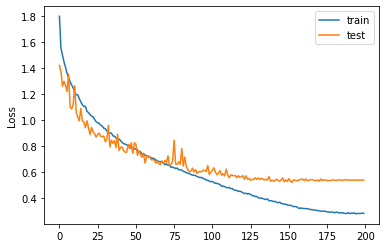

In [39]:
plt.plot(train_stat[:,1], label='train')
plt.plot(test_stat[:,1], label='test')
plt.ylabel("Loss")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_loss.svg")
plt.show()

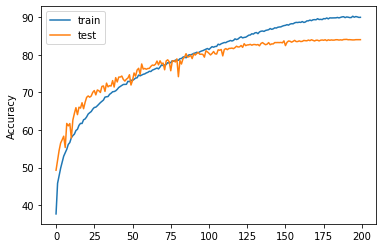

In [40]:
plt.plot(train_stat[:,2], label='train')
plt.plot(test_stat[:,2], label='test')
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"./output/plots/{model_name}_accs.svg")
plt.show()